# Variational Autoencoders
Dhanush Kamath | [GitHub](https://github.com/dhanushkamath) | [LinkedIn](https://www.linkedin.com/in/dhanushkamath/)

This notebook assumes that you are fairly familiar with the concepts of Convolutional Neural Networks and representation learning. If not, I would recommend watching Andrej Karpathy's [CS231n lecture videos](https://www.youtube.com/playlist?list=PLkt2uSq6rBVctENoVBg1TpCC7OQi31AlC) as they are, in my honest opinion, the best resource for learning CNNs on the internet. You can also find the lecture notes for the course [here](http://cs231n.github.io/).

If you're beginning to explore the field of Generative Deep Learning, a Variational Autoencoder (VAE) is ideal to kick off your journey. The VAE architecture is intuitive and simple to understand. Contrary to a discriminative model such as a CNN classifier, a generative model attempts to learn the underlying distribution of the data rather than classifying the data into one of many categories. A well trained CNN classifier would be highly accurate in differentiating an image of a car from that of a house. However, this does not accomplish our objective of generating images of cars and houses.

This example demonstrates the process of building and training a VAE using Keras to generate new faces. We shall be using the [CelebFaces Attributes (CelebA) Dataset](https://www.kaggle.com/jessicali9530/celeba-dataset) from Kaggle and [Google Colab](https://colab.research.google.com/) for training the VAE model.

## HOUSEKEEPING

### Downloading the dataset
The dataset can be downloaded directly into your Google Colab environment using the [Kaggle API](https://www.kaggle.com/docs/api) as shown below. You can refer to this [post](https://medium.com/@opalkabert/downloading-kaggle-datasets-into-google-colab-fb9654c94235) on Medium for more details.

In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

Upload Kaggle.json downloaded from your registered kaggle account

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mrhighsenberg","key":"e05897720b1964051303e59431b09859"}'}

In [3]:
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d jessicali9530/celeba-dataset

 99% 1.31G/1.33G [00:11<00:00, 80.2MB/s]
100% 1.33G/1.33G [00:11<00:00, 119MB/s] 


In [0]:
!mkdir data
!mkdir run

#Unzip the dataset downloaded from kaggle
from zipfile import ZipFile
with ZipFile('celeba-dataset.zip', 'r') as zipObj:
   # Extract all the contents of zip file in the data directory
   zipObj.extractall('./data/')

Caution (for Colab users) : Do not attempt to explore the directory using the viewer on the left as the page becomes unresponsive owing to the large size of the dataset.

### Imports

In [5]:
import os
from glob import glob
import numpy as np

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint 
from keras.utils import plot_model

Using TensorFlow backend.


### Run parameters

In [0]:
RUN_ID = '0001'
RUN_FOLDER = 'run/{}/'.format(RUN_ID)

if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

DATA_FOLDER = './data/img_align_celeba/'

###Data

In [7]:
filenames = np.array(glob(os.path.join(DATA_FOLDER, '*/*.jpg')))
NUM_IMAGES = len(filenames)
print("Total number of images : " + str(NUM_IMAGES))

Total number of images : 202599


As the dataset is quite large, we shall create an <i>ImageDataGenerator</i> object and employ it's member function - <i>flow_from_directory</i> to define the flow of data directly from disk rather than loading the entire dataset into memory. The ImageDataGenerator can also be used to dynamically apply various transformations for image augmentation which is particularly useful in the case of small datasets.

I highly encourage you to refer to the [documentation](https://keras.io/preprocessing/image/#flow_from_directory) for understanding the various parameters of the dataflow function. 

In [8]:
INPUT_DIM = (128,128,3) # Image dimension
BATCH_SIZE = 512
Z_DIM = 200 # Dimension of the latent vector (z)

data_flow = ImageDataGenerator(rescale=1./255).flow_from_directory(DATA_FOLDER, 
                                                                   target_size = INPUT_DIM[:2],
                                                                   batch_size = BATCH_SIZE,
                                                                   shuffle = True,
                                                                   class_mode = 'input',
                                                                   subset = 'training'
                                                                   )

Found 202599 images belonging to 1 classes.


## VANILLA AUTOENCODER

Before delving into a Variational Autoencoder, it is crucial to analyse a simple Autoencoder. 

A simple or Vanilla Autoencoder consists of two neural networks - an Encoder and a Decoder. An Encoder is responsible for converting an image into a compact lower dimensional vector (or latent vector). This latent vector is a compressed representation of the image. The Encoder therfore maps an input from the higher dimensional input space to the lower dimensional latent space. This is similar to a CNN classifier. In a CNN classifier, this latent vector would be subsequently fed into a softmax layer to compute individual class probabilities. However in an Autoencoder, these outputs are fed into the Decoder. The Decoder is a different neural network that tries to reconstruct the image, thereby mapping from the lower dimenstional latent space to the higher dimensional output space. The Encoder and Decoder therefore perform mappings that are exactly opposite to each other. 

<br>
<img src="https://upload.wikimedia.org/wikipedia/commons/2/28/Autoencoder_structure.png"> 
<br><i>Source : en.wikipedia.org/wiki/Autoencoder</i>

<br><br>
Consider the following analogy to understand this better. Imagine you're playing a game with your friend over the phone. The rules of the game are simple. You are presented with a number of different cylinders. Your task is to describe the cylinders to your friend who will then attempt to recreate them out of modelling clay. You are forbidden from sending pictures. How will you convey this information? 

Since any cylinder can be constructed with two parameters - its height and diameter, the most efficient strategy would be to estimate these two measures and convey them to your friend. Your friend, upon receiving this information can then reconstruct the cylinder. In this example, it is quite evident that you are performing the function of an Encoder by condensing visual information into two quantities. Your friend on the contrary, is performing the function of a Decoder by utilising this condensed information to recreate the cylinder.




### Encoder Architecture


####Building the Encoder

In [0]:
# ENCODER
def build_encoder(input_dim, output_dim, conv_filters, conv_kernel_size, 
                  conv_strides, use_batch_norm = False, use_dropout = False):
  
  # Clear tensorflow session to reset layer index numbers to 0 for LeakyRelu, 
  # BatchNormalization and Dropout.
  # Otherwise, the names of above mentioned layers in the model 
  # would be inconsistent
  global K
  K.clear_session()
  
  # Number of Conv layers
  n_layers = len(conv_filters)

  # Define model input
  encoder_input = Input(shape = input_dim, name = 'encoder_input')
  x = encoder_input

  # Add convolutional layers
  for i in range(n_layers):
      x = Conv2D(filters = conv_filters[i], 
                  kernel_size = conv_kernel_size[i],
                  strides = conv_strides[i], 
                  padding = 'same',
                  name = 'encoder_conv_' + str(i)
                  )(x)

      x = LeakyReLU()(x)
    
  # Required for reshaping latent vector while building Decoder
  shape_before_flattening = K.int_shape(x)[1:] 
  
  x = Flatten()(x)

  # Define model output
  encoder_output = Dense(output_dim, name = 'encoder_output')(x)

  return encoder_input, encoder_output, shape_before_flattening, Model(encoder_input, encoder_output)

<br><br>
The architecture of the Encoder, as shown below, consists of a stack of convolutional layers followed by a dense (fully connected) layer which outputs a vector of size 200.


<i>Note : The combination of padding = 'same' and stride = 2 will produce an output tensor half the size of the input tensor in both height and width. The depth/channels aren't affected as they are numerically equal to the number of filters. </i>
<br><br>

In [10]:
encoder_input, encoder_output,  shape_before_flattening, encoder  = build_encoder(input_dim = INPUT_DIM,
                                    output_dim = Z_DIM, 
                                    conv_filters = [32, 64, 64, 64],
                                    conv_kernel_size = [3,3,3,3],
                                    conv_strides = [1,2,2,1])

encoder.summary()






Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 128, 128, 3)       0         
_________________________________________________________________
encoder_conv_0 (Conv2D)      (None, 128, 128, 32)      896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 32)      0         
_________________________________________________________________
encoder_conv_1 (Conv2D)      (None, 64, 64, 64)        18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64, 64, 64)        0         
_________________________________________________________________
encoder_conv_2 (Conv2D)      (None, 32, 32, 64)        36928     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 32, 32, 64)       

####Building the Decoder


In [0]:
# Decoder
def build_decoder(input_dim, shape_before_flattening, conv_filters, conv_kernel_size, 
                  conv_strides):

  # Number of Conv layers
  n_layers = len(conv_filters)

  # Define model input
  decoder_input = Input(shape = (input_dim,) , name = 'decoder_input')

  # To get an exact mirror image of the encoder
  x = Dense(np.prod(shape_before_flattening))(decoder_input)
  x = Reshape(shape_before_flattening)(x)

  # Add convolutional layers
  for i in range(n_layers):
      x = Conv2DTranspose(filters = conv_filters[i], 
                  kernel_size = conv_kernel_size[i],
                  strides = conv_strides[i], 
                  padding = 'same',
                  name = 'decoder_conv_' + str(i)
                  )(x)
      
      # Adding a sigmoid layer at the end to restrict the outputs 
      # between 0 and 1
      if i < n_layers - 1:
        x = LeakyReLU()(x)
      else:
        x = Activation('sigmoid')(x)

  # Define model output
  decoder_output = x

  return decoder_input, decoder_output, Model(decoder_input, decoder_output)

<br><br>
Recall that the it is the function of the Decoder to reconstruct the image from the latent vector. Therefore it is necessary to define the decoder so as to increase the size of the activations gradually through the network. This can be achieved either through the [UpSampling2D](https://keras.io/layers/convolutional/#upsampling2d) layer or the [Conv2DTransponse](https://keras.io/layers/convolutional/#conv2dtranspose) layer.

Here the Conv2DTranspose Layer is employed. This layer produces an output tensor double the size of the input tensor in both height and width.

<i>Note : The Decoder, in this example, is defined to be a mirror image of the encoder, which is not mandatory.</i>

<br><br>

In [12]:
decoder_input, decoder_output, decoder = build_decoder(input_dim = Z_DIM,
                                        shape_before_flattening = shape_before_flattening,
                                        conv_filters = [64,64,32,3],
                                        conv_kernel_size = [3,3,3,3],
                                        conv_strides = [1,2,2,1]
                                        )
decoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 65536)             13172736  
_________________________________________________________________
reshape_1 (Reshape)          (None, 32, 32, 64)        0         
_________________________________________________________________
decoder_conv_0 (Conv2DTransp (None, 32, 32, 64)        36928     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
decoder_conv_1 (Conv2DTransp (None, 64, 64, 64)        36928     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 64, 64, 64)        0   

#### Attaching the Decoder to the Encoder

In [13]:
# The input to the model will be the image fed to the encoder.
simple_autoencoder_input = encoder_input

# Output will be the output of the decoder
simple_autoencoder_output = encoder_output

simple_autoencoder = Model(encoder_input, decoder(encoder_output))

simple_autoencoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 128, 128, 3)       0         
_________________________________________________________________
encoder_conv_0 (Conv2D)      (None, 128, 128, 32)      896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 32)      0         
_________________________________________________________________
encoder_conv_1 (Conv2D)      (None, 64, 64, 64)        18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64, 64, 64)        0         
_________________________________________________________________
encoder_conv_2 (Conv2D)      (None, 32, 32, 64)        36928     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 32, 32, 64)        0   

### COMPILATION

In [0]:
LEARNING_RATE = 0.0005

In [15]:
optimizer = Adam(lr = LEARNING_RATE)

def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

simple_autoencoder.compile(optimizer=optimizer, loss = r_loss)

In [16]:
simple_autoencoder.fit_generator(data_flow, 
                                 shuffle=True, 
                                 epochs = 20, 
                                 initial_epoch = 0, 
                                 steps_per_epoch=NUM_IMAGES / BATCH_SIZE)




Epoch 1/20





396/395 [==============================] - 230s 580ms/step - loss: 0.0252
Epoch 2/20
396/395 [==============================] - 213s 537ms/step - loss: 0.0090
Epoch 3/20
 49/395 [==>...........................] - ETA: 3:06 - loss: 0.0076

KeyboardInterrupt: ignored

In [0]:

example_batch = next(data_flow)
example_images = example_batch[0]

In [19]:
example_images[:10].shape

(10, 128, 128, 3)

In [0]:
import matplotlib.pyplot as plt

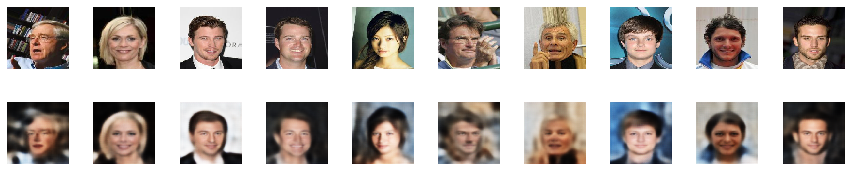

In [22]:
n_to_show = 10


reconst_images = simple_autoencoder.predict(example_images[:10])

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+1)
    sub.axis('off')        
    sub.imshow(img)

for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    sub.axis('off')
    sub.imshow(img)